# Primeiros passos com o HydroBR
- Obtenção do inventário de estações
- Download de dados
- Visualização de disponibilidade temporal

In [1]:
#Importando as bibliotecas
import geopandas as gpd
from shapely.geometry import Point
import hydrobr

C:\Users\User\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\User\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
#Abrindo o shapefile da área de interesse
area = gpd.read_file(r'shapefiles/bacia_doce.shp')
area.plot()

HydroBr tem duas funções para obter a lista de estações da ANA:
- hydrobr.get_data.ANA.list_prec_stations - Para obter a lista de estações de precipitação
- hydrobr.get_data.ANA.list_flow_stations - Para obter a lista de estações de vazão/nível

As colunas incluem:
- Data da primeira medição (FirstDate)
- Data da última medição (EndDate)
- Número de anos com dados (NYD)
- Porcentagem de falhas entre a primeira e última medição (MD)
- Número de anos sem nenhuma falha (N_YWOMD)
- Porcentagem de anos com falhas

In [3]:
# Obtendo a lista de estações de vazão/nível da ANA
lista_flu = hydrobr.get_data.ANA.list_flow_stations()
lista_flu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3771 entries, 0 to 3770
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          3771 non-null   object 
 1   Code          3771 non-null   object 
 2   Type          3771 non-null   int64  
 3   DrainageArea  3707 non-null   float64
 4   SubBasin      3771 non-null   int64  
 5   City          3770 non-null   object 
 6   State         3771 non-null   object 
 7   Responsible   3771 non-null   object 
 8   Latitude      3771 non-null   float64
 9   Longitude     3771 non-null   float64
 10  StartDate     3771 non-null   object 
 11  EndDate       3771 non-null   object 
 12  NYD           3771 non-null   int64  
 13  MD            3771 non-null   float64
 14  N_YWOMD       3771 non-null   int64  
 15  YWMD          3771 non-null   float64
dtypes: float64(5), int64(4), object(7)
memory usage: 471.5+ KB


O próximo passo é criar um GeoDataFrame com a lista de estações

In [4]:
pontos = [Point(x) for x in zip(lista_flu.Longitude,lista_flu.Latitude)] # Criando uma lista de geometrias no formato de ponto
crs={'proj':'latlong','ellps':'WGS84','datum':'WGS84','no_def':True} # Definindo o sistema de coordenadas
lista_flu_geo = gpd.GeoDataFrame(lista_flu, geometry=pontos,crs=crs) # Criando o geodataframe

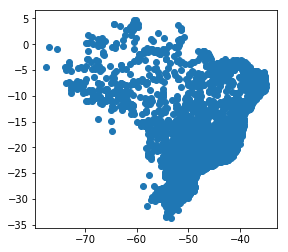

In [5]:
lista_flu_geo.plot()

Filtrando as estações que estão nas bacias

In [6]:
indices = lista_flu_geo.geometry.within(area.geometry[0]) # Selecionando os indices das estações que estão dentro da bacia
lista_selecionada = lista_flu_geo[indices] # Filtrando as estações
lista_selecionada.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 152 entries, 1521 to 1686
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Name          152 non-null    object  
 1   Code          152 non-null    object  
 2   Type          152 non-null    int64   
 3   DrainageArea  151 non-null    float64 
 4   SubBasin      152 non-null    int64   
 5   City          152 non-null    object  
 6   State         152 non-null    object  
 7   Responsible   152 non-null    object  
 8   Latitude      152 non-null    float64 
 9   Longitude     152 non-null    float64 
 10  StartDate     152 non-null    object  
 11  EndDate       152 non-null    object  
 12  NYD           152 non-null    int64   
 13  MD            152 non-null    float64 
 14  N_YWOMD       152 non-null    int64   
 15  YWMD          152 non-null    float64 
 16  geometry      152 non-null    geometry
dtypes: float64(5), geometry(1), int64(4), obje

Plotando as estações e a área de interesse

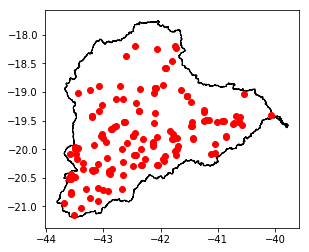

In [7]:
base = area.plot(color='white', edgecolor='black')
lista_selecionada.plot(ax=base,marker='o',color='red')

Baixando as 15 primeiras estações

In [8]:
codigos = lista_selecionada.Code.to_list()
dados_flu = hydrobr.get_data.ANA.flow_data(codigos) # Baixando as estações
dados_flu.info()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [08:39<00:00,  3.35s/it]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34638 entries, 1925-12-01 to 2020-09-30
Freq: D
Columns: 152 entries, 55780002 to 56998400
dtypes: float64(152)
memory usage: 40.4 MB


Plotando a disponibilidade temporal dos dados

In [9]:
from plotly.offline import plot
gantt_fig = hydrobr.Plot.gantt(dados_flu)
#Atualizando o layout da figura
gantt_fig.update_layout(
    autosize=False,
    width=1800,
    height=2000,
    xaxis_title = 'Ano',
    yaxis_title = 'Código da Estação',
    font=dict(family="Courier New, monospace", size=12))

#Plotando
plot(gantt_fig,filename='Gantt_Doce' + '.html')

'Gantt_Doce.html'